In [2]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the image points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [1]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree

/var/folders/nw/yrny75552dl0y5w78q4z6cdm0000gn/T/ipykernel_6435/2285484419.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
#Load shapefile

my_shapefile_path = "/Users/livdreyerjohansen/Downloads/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
my_shp = gpd.read_file(my_shapefile_path)
#print(my_shp)

In [3]:
#Access to Mapillary API
id = 6271859919532158
clienttoken = "MLY|6271859919532158|486bcdece7a665eb89a5803f2994b4c9"
clientsecret = "MLY|6271859919532158|891f85315dab6cea6fce4efaac3f1683"

#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]


#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
print(df_points)



1984
                    ID                   geometry
0     1249857975838941  POINT (12.55717 55.67399)
1     1441631339640436  POINT (12.56186 55.67100)
2     2062022120619185  POINT (12.54057 55.67440)
3     2862436603975062  POINT (12.54589 55.67040)
4     1385460825312560  POINT (12.55513 55.67377)
...                ...                        ...
1979  3929154853832771  POINT (12.56187 55.66302)
1980  1270881860414930  POINT (12.55707 55.66085)
1981  2889006411369292  POINT (12.55798 55.66909)
1982  2980553185501447  POINT (12.54183 55.66622)
1983  1676395356071383  POINT (12.54365 55.66632)

[1984 rows x 2 columns]


In [4]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)


print(df_lines)




               ID                                           geometry
47      174472823  LINESTRING (12.54255 55.66452, 12.54272 55.66479)
188     174472925  LINESTRING (12.54329 55.66718, 12.54352 55.667...
515     174477311  LINESTRING (12.56242 55.67385, 12.56234 55.67394)
845     174474161  LINESTRING (12.54380 55.67105, 12.54376 55.67109)
849     174477032  LINESTRING (12.56357 55.67126, 12.56361 55.67128)
...           ...                                                ...
301660  174474898  LINESTRING (12.54812 55.66269, 12.54809 55.66274)
301676  174475046  LINESTRING (12.55384 55.66429, 12.55399 55.66431)
301682  174475045  LINESTRING (12.55396 55.66422, 12.55400 55.664...
301756  174475042  LINESTRING (12.55399 55.66431, 12.55398 55.664...
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)

[2442 rows x 2 columns]


<Axes: >

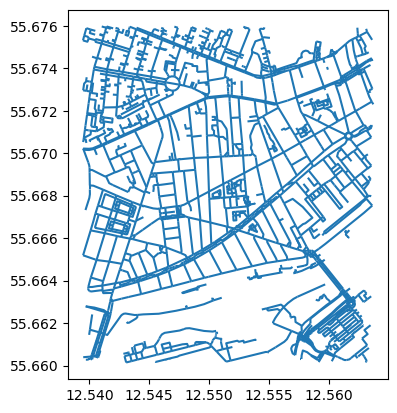

In [5]:
df_lines["geometry"].plot()

EPSG:4326
None


/var/folders/nw/yrny75552dl0y5w78q4z6cdm0000gn/T/ipykernel_6435/667649069.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.00008).plot(ax=ax,alpha=0.5)


<Axes: >

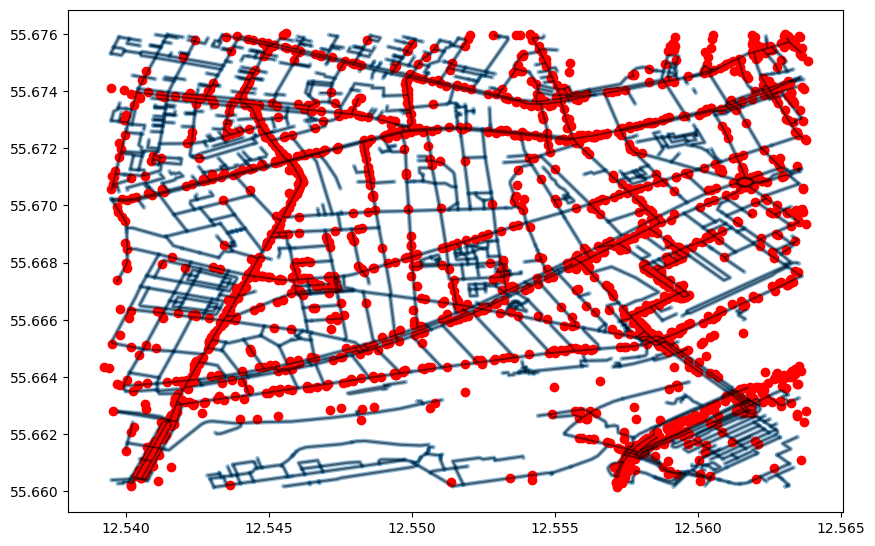

In [21]:
print(df_lines.crs)
print(df_points.crs)
fig, ax = plt.subplots(figsize = (10,10))
df_lines = df_lines.to_crs(epsg=4326)


df_lines["geometry"].buffer(0.00008).plot(ax=ax,alpha=0.5)

df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")

df_points["geometry"].plot(ax=ax,color = "r")

In [9]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

/var/folders/nw/yrny75552dl0y5w78q4z6cdm0000gn/T/ipykernel_6085/3933553022.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001)


In [10]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,2448443745322543,POINT (12.54242 55.66417),132437.0,174472807.0
1,2909680612580685,POINT (12.54994 55.66821),73930.0,174475938.0
1,2909680612580685,POINT (12.54994 55.66821),91646.0,174475912.0
1,2909680612580685,POINT (12.54994 55.66821),105568.0,174475939.0
1,2909680612580685,POINT (12.54994 55.66821),130046.0,174475940.0
...,...,...,...,...
1980,2795116110800526,POINT (12.55823 55.66643),121074.0,174475744.0
1981,3740197672758527,POINT (12.55785 55.66617),121074.0,174475744.0
1982,2903309886604513,POINT (12.54290 55.66522),112948.0,174472868.0
1983,3556338797928282,POINT (12.55093 55.67575),2819.0,174476391.0


<Axes: >

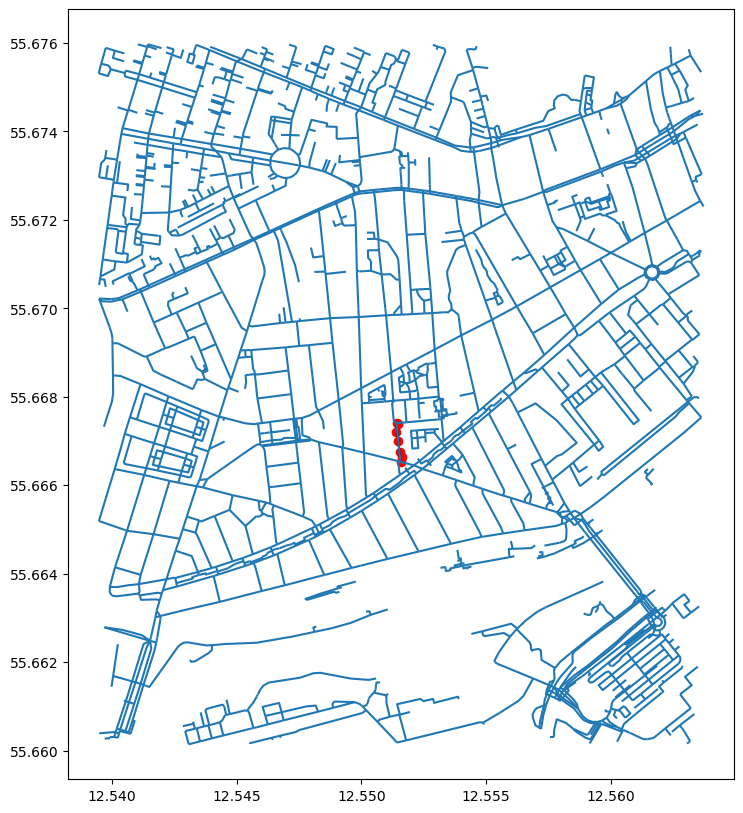

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

In [12]:
# https://autogis-site.readthedocs.io/en/2019/notebooks/L3/nearest-neighbor-faster.html

(55.660144, 55.675971)

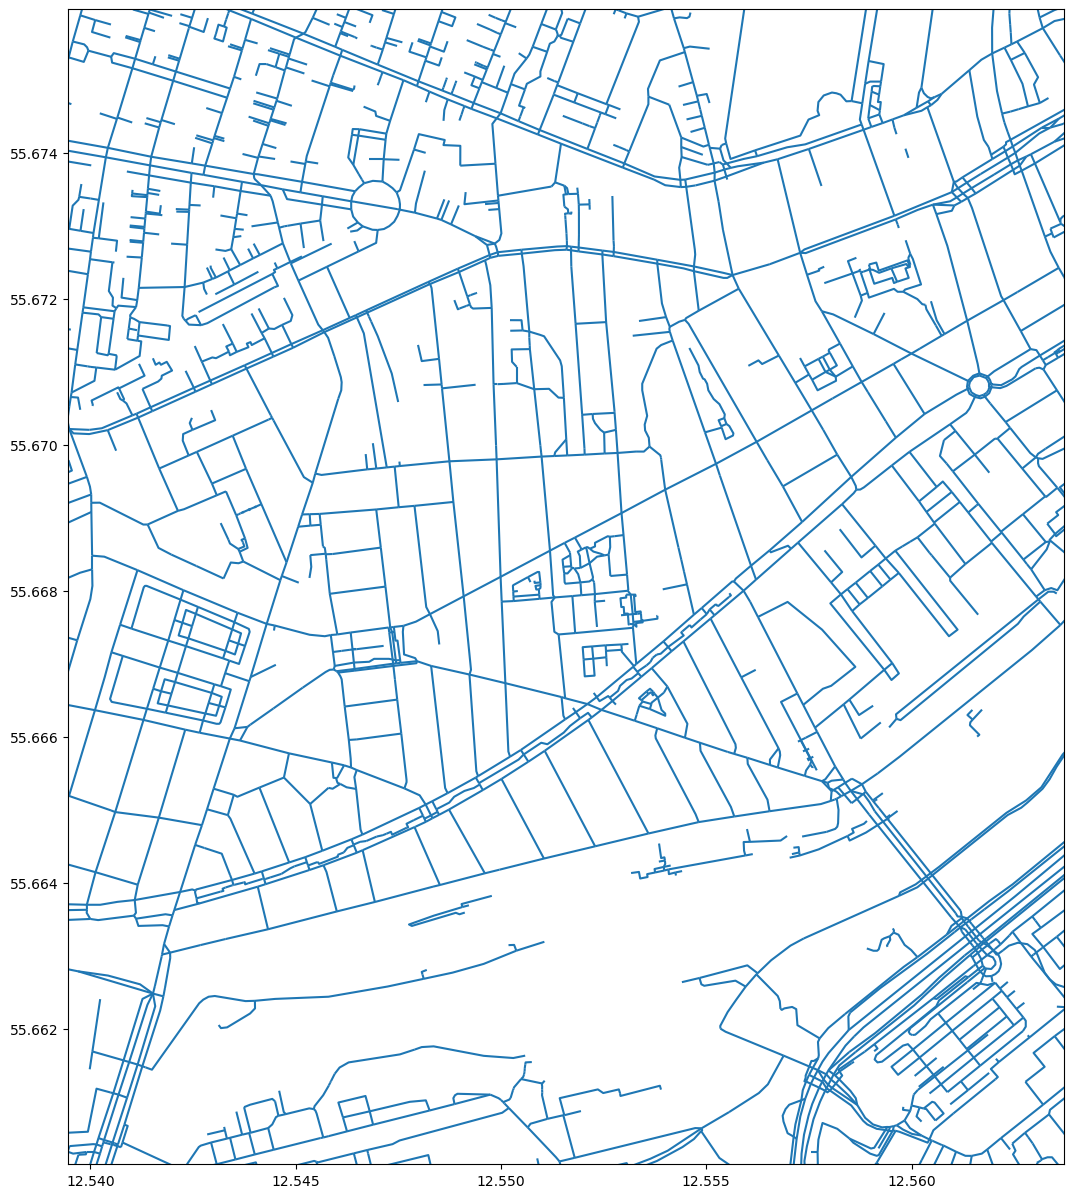

In [13]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)